#### Experiment (I). Hiearhical Counting

In [1]:
# The issue with this counting sequence is that it has batch size of 1 only 
# it's fine for now, but clearly a fourier series decomposition is more beautiful

# (I). Counting Sequence
# --------------------------------------------------------------------------------
from collections import defaultdict
import torch

# (I.1) Generate Counting Sequence
# ----------------------------------------------------
def generate_level(l: int, seq: list, t: int, L: int, K: int): 
    if l < L:
        seq[l] += str(l)
        if t % K == 0: 
            return generate_level(l+1, seq, t // K, L, K)
    return seq

def generate_count_seq(L: int, K: int, T: int): 
    seq = defaultdict(str)
    for t in range(1, T+1): 
        seq = generate_level(0, seq, t, L, K)
    return seq
# ----------------------------------------------------

# (I.2) Tokenizer (basic integer tokenizer)
# ----------------------------------------------------

class TinyTokenizer: 
    def __init__(self, vocab: dict):
        self.vocab = {str(k): v for k, v in vocab.items()}
        self.vocab_size = len(vocab)

    def __call__(self, seq: str):
        return [self.vocab[c] for c in seq]

# ----------------------------------------------------


# (I.3) Tensor idx sequence preparation 
# ----------------------------------------------------

L = 3
K = 2
T = 200

data = generate_count_seq(L, K, T)
tokenizer = TinyTokenizer({str(k): k for k in range(10)})

idx = [tokenizer(seq) for seq in data.values()]
idx += [[] for _ in range(L - len(idx))]
samples = [(idx, None)]

from model import GATConfig, GAT, HierSeq
from utils import stream_print_hseq
from torch.optim import Adam 

config = GATConfig(K=K, L=L, n_embd=128, n_head=4, device="cpu", _compile=False)
gat = GAT(config)

# .from_hiearchical_data has error: prepared token is NOT interleaved with correct causal ordering
batch_data = HierSeq.from_hierarchical_data(samples, K=gat.K, L=gat.L)
stream_print_hseq(batch_data) # sanity check

# Batched Forward Propagation
epochs = 30
# gat.train()


# Training Loop : learning just fine -- loss reduces quickly
# ----------------------------------------------------
optimizer = Adam(gat.parameters(), lr=1e-3)

for epoch in range(epochs):
    loss = gat(batch_data)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")
    # break
# ----------------------------------------------------


Hierarchical Sequence K=2 L=3 (aligned by timestamp):
-------------------------------------------------------
Level 2:                 [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2] 
Level 1:         [1]     [1]     [1]     [1]     [1]     [1]     [1]     [1

In [2]:
from utils import * 


test_data = generate_count_seq(L, K, 1)
idx = [tokenizer(seq) for seq in test_data.values()]
idx += [[] for _ in range(L - len(idx))]
test_samples = [(idx, None)]
test_batch_data = HierSeq.from_hierarchical_data(test_samples, K=gat.K, L=gat.L)


for _ in range(25): 
    gat.generate(test_batch_data)
    stream_print_hseq(test_batch_data)
    time.sleep(0.5)


Hierarchical Sequence K=2 L=3 (aligned by timestamp):
-------------------------------------------------------
Level 2:                 [2]             [2]             [2]                 
Level 1:         [1]     [1]     [1]     [1]     [1]     [1]     [1]         
Level 0:     [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] 
Total tokens: 26, Max timestamp: 16



#### Self-Organizing Reinforcement Learning
1. A more exciting question is how can I build a GAT module for a Snake game? It'll be the natural test-bed for SoRL -- a snake with inner-monologue. 
2. Decision Abstractive Transformer (DAT).


In [1]:
from snake import SnakeGameEngine, collect_trajectories, RandomAgent
from utils import HierTraj, data_sanity_check
from constant import PLACE_HOLDER_STATE_TOK, PLACE_HOLDER_ACTION_TOK

env = SnakeGameEngine(width=10, height=10)

# This is a make-shift data collection pipeline, the abstract tokens are complete false. 
# The proper way to collect data, per SoRL, is to 'simulate' multiple actions on the environment and store the HierTraj state directly
# in that sense, the code snippet in the middle is not useful...

# A way to use 'expert trajectory' is to take in the 'trajectories', and have the agent 'learn / explore' on what abstract tokens can be 
# used to explain the trajectory. This is very similar to the 'intuitive-physics' based 'learning by surprise' or 'active learning from obs' 
# idea. 

# For what is worth, the mid-snippet is useless (besides serving as a toy-case on which we test on SSL training of GAT)

# Collect trajectories
trajectories = collect_trajectories(env, RandomAgent(env), num_episodes=5, device="cpu")

samples = []
for trajectory in trajectories: 

    n_state = trajectory[0].size(0)
    placeholder_tokens = [PLACE_HOLDER_STATE_TOK if i % 2 == 0 else PLACE_HOLDER_ACTION_TOK for i in range(2*n_state-1)]
    sample = ([placeholder_tokens, [3, 9, 4, 2], [19, 14]], None)
    samples.append(sample)

batch_data = HierTraj.from_hierarchical_data(samples, K=3, L=3)
data_sanity_check(batch_data, trajectories)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
Episode 0: Score=0, Reward=-11.0
Episode 1: Score=0, Reward=-10.9
Episode 2: Score=0, Reward=-10.9
Episode 3: Score=1, Reward=-0.7999999999999989
Episode 4: Score=0, Reward=-13.200000000000001
Sanity check passed: total 153 0-th level tokens (state & action)
Sanity check passed: 79 state tokens in data, 79 state tokens in trajectories
Sanity check passed: 74 action tokens in data, 74 action tokens in trajectories
Sanity check passed: 183 (action/state/abstract) tokens in data


In [2]:
from model import DAT, DATConfig

# DAT model 

config = DATConfig(
    n_layer=4,
    n_head=2,
    n_embd=32,
    K=2,
    L=3,
    vocab_size_list=[64, 32],
    device="cpu",
    _compile=True,
)

# Snake specific encoder & decoder for state & action
from snake import StateEncoder, StateDecoder, ActionEncoder, ActionDecoder

state_encoder = StateEncoder(height=10, width=10, feature_dim=config.n_embd)
state_decoder = StateDecoder(height=10, width=10, feature_dim=config.n_embd)
action_encoder = ActionEncoder(action_size=4, feature_dim=config.n_embd)
action_decoder = ActionDecoder(action_size=4, feature_dim=config.n_embd)

dat = DAT(config, state_encoder, state_decoder, action_encoder, action_decoder)

In [3]:
# compute loss
loss = dat(batch_data, trajectories)

# generate & update 
new_batch_data, new_trajectories = dat.generate(batch_data, trajectories)

# act: produce action tokens (if there already exists action-tokens un-grounded with reward, skip it)
pairs = dat.act(batch_data, trajectories) # list of (sample_idx, action_idx)


In [4]:
# Validate on 'order of generation'
from utils import test_dat_gen_order

# Sanity check-up function (order of generation)
test_dat_gen_order(dat, env, L=3, K=2, n_gen=10)


Hierarchical Trajectory K=2 L=3 (aligned by timestamp):
-------------------------------------------------------
Level 2:              [0]     
Level 1:      [0]     [0]     
L0-State: [s] [s] [s] [s]     
L0-Action:    [a] [a] [a] [a] 
Total tokens: 11, Max timestamp: 4



In [ ]:
# Create 2x2 visualization for first 4 samples
# --------------------------------------------------------------

from vis import visualize_backtrack
from utils import * 
import matplotlib.pyplot as plt

# Create 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Backtrack Visualization for First 4 Samples', fontsize=16)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Process first 4 samples
num_samples = min(4, batch_data.indices.max().item() + 1)

for i in range(num_samples):
    sample_idx = i
    
    # Get sample-level perplexity data
    per_sample_ppt, per_sample_timestamps, max_abs_ts = get_sample_level_ppl(batch_data, ppt, level=0)
    
    # Extract data for current sample
    sample_timestamps = per_sample_timestamps[sample_idx][:max_abs_ts + batch_data.K]
    sample_ppt = per_sample_ppt[sample_idx][:max_abs_ts + batch_data.K]
    
    # Select current subplot
    ax = axes_flat[i]
    
    # Plot the data
    ax.plot(sample_timestamps.cpu().numpy(), sample_ppt.cpu().numpy(), 
            'b-', linewidth=1.5, label='Perplexity')
    
    # Add threshold line
    ax.axhline(y=buffer.ppl_thres, color='r', linestyle='--', 
               linewidth=1, label=f'Threshold ({buffer.ppl_thres:.2f})')
    
    # Mark critical timestamps
    critical_mask = sample_ppt > buffer.ppl_thres
    if critical_mask.any():
        critical_ts = sample_timestamps[critical_mask]
        critical_ppt = sample_ppt[critical_mask]
        ax.scatter(critical_ts.cpu().numpy(), critical_ppt.cpu().numpy(), 
                  color='red', s=50, zorder=5, label='Critical Points')
    
    # Mark backtrack points (where cts changed for this sample)
    if sample_idx < len(cts):
        backtrack_ts = cts[sample_idx] + 1
        if backtrack_ts > 0:
            ax.axvline(x=backtrack_ts, color='green', linestyle=':', 
                      linewidth=1.5, label=f'Backtrack (t={backtrack_ts})')
    
    # Styling
    ax.set_xlabel('Timestamp', fontsize=10)
    ax.set_ylabel('Perplexity', fontsize=10)
    ax.set_title(f'Sample {sample_idx}', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='upper right')
    
    # Set y-axis limits for better visualization
    ax.set_ylim([0, max(10, sample_ppt.max().item() * 1.1)])

# Hide unused subplots if less than 4 samples
for i in range(num_samples, 4):
    axes_flat[i].axis('off')

plt.tight_layout()
plt.show()

print(f"Visualized {num_samples} samples in 2x2 grid")


In [ ]:
# Use the new helper function for cleaner multi-sample visualization
from vis import visualize_multi_sample_backtrack

# Create 2x2 grid visualization for first 4 samples
fig, axes = visualize_multi_sample_backtrack(batch_data, ppt, cts, buffer, num_samples=4)
plt.show()


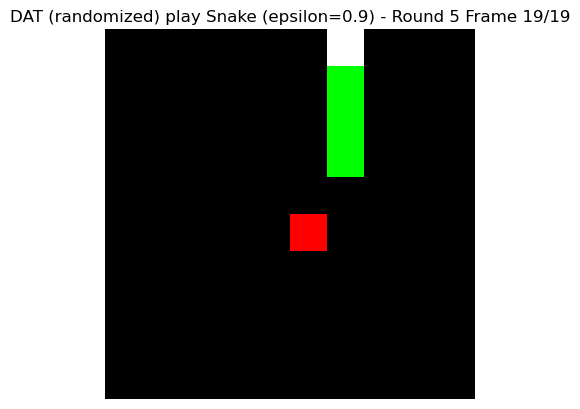

: 

In [ ]:
# Does DAT dream of playing snake game?

# from agent import HiearchicalAgent
from snake import SnakeGameEngine
from utils import draw_gif
from agent import collect_dat_game_play_frames
from agent import HiearchicalAgent

# Environment
env = SnakeGameEngine(width=10, height=10)

# DAT Agent (Snake specific agent)
# agent = HiearchicalAgent(dat, env.reset(), "cpu")

# DAT plays the snake game
# --------------------------------------------------------------------------------------------------------------------------
epsilon = 0.9
frames = collect_dat_game_play_frames(dat, env, epsilon=epsilon)
draw_gif(frames, txt=f"DAT (randomized) play Snake (epsilon={epsilon})", path="./visual/dat_snake.gif")

Training Algorithm

- Learn to Explain (GAT)
Trajectory only data --> Sample --> Train

- Learn to Explore (DAT)
No data --> Sample --> Extend & Environment Interaction --> Train

Crazier idea; 
- number of learning step matters, when it's big, we get more instability, but better search ability improvement
- when we have 'similar abstractions', we want to 'learn more'
- when we have 'dis-similar abstraction' (picked one has clear advantage) -- do we 'learn less'? 

Experiment on SSL for abstract & trajectory tokens 

(temperature=0.0, data_size=1)
1. Simply pick any abstraction (entire sequence), and train with ssl (abstract & trajectory) works for improving 'search ability'. 
- Improve ppl percentage: 25% / 21% / 7% --- traj loss ~ 1.3 / 1.3
2. Add one abstract token (pin-down one option and train with abstract / trajectory ssl loss)
- Improve ppl percentage: 18% / 17% -- traj loss ~0.5 / 0.529
3. I increment 't_search' with a curriculum design following: 3->6->9->12->15->None
- Improve ppl percentage: 69% -- traj loss ~ 0.5 | the learning is very much transferrable, the last lesson has a bigger jump, but it has a small initial abs_loss, whilst the ssl_loss decreases very fast, too. I suspect this is a better strategy for ssl & improve_ppl_percentage

$\textit{Remark 1}$: The excitement here, is that for the first time, we've verifed that JUST TRAIN with ssl works to improve traj_loss with SPECIFIC abs token choice made BY THE POLICY model)

(temperature=0.0, data_size=3)
1. one abstract token (picked and pinned), train with abstract / trajectory ssl loss
- Improve ppl percentage: 25% | traj loss ~ 0.76



So obviously, we should perform incremental search. 

1. Compare SoRL v3 with baseline transformer | evaluate on OOD case
2. Evaluate SoRL v3 on arithmetic dataset, where evaluation etc. are more obvious and straight-forward 
3. Put things on GPU device

$\textbf{SoRL (GAT)}$
1. Group advantage computation 
2. Surrogate loss computation

The key for learning from experience is learning from failure

In [20]:
from dataset.nbody import NBodyDataset 

dataset = NBodyDataset(
    n_bodies=2,
    patterns=['circular'],
    T=20,
    filepath='dataset/nbody/2body_100.bin',
    num_data=100,
    K=3, 
    L=2
).build()

# dataset.sequences[0]

Generating circular with n=2, n_context=3...
Saved 100 sequences to dataset/nbody/2body_100.bin


In [1]:
from dataset.arithmetic import ArithmeticDataset

val_dataset = ArithmeticDataset(
    min_digit=1,
    max_digit=3,
    num_data = 50,
    filepath="dataset/multiplication/50-123.bin"
).build()

# dataset = ArithmeticDataset(
#     min_digit=1,
#     max_digit=3,
#     num_data=100000,
#     filepath="dataset/multiplication/100K-123.bin"
# ).build()

100%|██████████| 50/50 [00:00<00:00, 587437.54it/s]

Saved 50 sequences to dataset/multiplication/50-123.bin


In [1]:
# learn-to-explain (GAT) | one batch ver.

# (1). Initialize Data Buffer with trajectory-only data 

from model import GATConfig, GAT
from dataset.arithmetic import ArithmeticDataset

from dataclasses import asdict
from search import SORLConfig 
import wandb

gat_config = GATConfig(K=3, L=2, n_embd=128, n_head=4, n_layer=4, device="cpu", _compile=False,
                       vocab_size_list=[17, 8])
gat = GAT(gat_config)


config = SORLConfig(gat_config=gat_config, 
           n_generations=4, temperature=1.0, num_iterations=2, 
           joint_steps=10, context_length=1024, learning_rate=1e-3,
           dataset_name="100K-123", 
           dataset_path="dataset/multiplication/100K-123.bin",
           id_validate_dataset_path="dataset/multiplication/2k-123.bin",
           ood_validate_dataset_path="dataset/multiplication/2k-123.bin")

# load dataset
dataset = ArithmeticDataset.from_file(config.dataset_path)
id_val_dataset = ArithmeticDataset.from_file(config.id_validate_dataset_path)


# gat.load_checkpoint("experiment/nbody/SoRL-GRPO-per-token-alternate-nbody.pt")

1. Including window of size 100 & 0.1 abstraction switch ratio + search annealing phase change (with no return tickets). 
- search phase collapse the search advantage from 20 percent to 2 ~ 6 percent. 

In [2]:
# Benchmark RL & SSL combination strategies 
# (I). Pick the best & learn it 
# -------------------------------------------------------------
import copy 
import wandb
import torch
from search import compute_ssl_loss, get_batch, eval_search_improvement
from search import compute_abs_ssl_loss
from search import sorl_search, observe_abstraction, generate_rollout_data, sorl_search_v2
from search import compute_curriculum_t_increment, eval_ppl_with_search, curriculum_iter
from search import PhaseScheduler, adjust_threshold

n = 3 # bigger n seems to destablize the training (?)
temperature = 1.0
 # with n=2, random sample (higher temperature) compared to deterministic search, which is better (?)
num_iterations = 200
context_length = 1024
num_loops = 1
global_step = 0 
ratio_target = 0.2

# Thought: the easier way out is to just increase the threshold? I do recall that threshold itself doesn't help, it only help when combined with 
#          bigger inner_steps

scheduler = PhaseScheduler(init_joint_steps=1, init_abs_switch_ppl_threshold=0.000000)

optimizer = torch.optim.Adam(gat.parameters(), lr=1e-3)
gat.train() 

# curriculum
t_search = 0
t_delta, t_max = compute_curriculum_t_increment(num_iterations=num_iterations, context_length=context_length, K=gat.K, max_ts=max(dataset.lengths),
                                                num_loops=num_loops)

while global_step < num_iterations: 

    batch_data = get_batch(dataset.sequences, dataset.lengths, context_length // n, gat.L, gat.K)

    t_search = min(t_search + t_delta, t_max)

    with torch.no_grad(): 
        repeat_batch, switch_ratio, rollout_advantages = sorl_search_v2(gat, batch_data, n, temperature, t_search, switch_abs_ppl_threshold=scheduler.abs_switch_ppl_threshold) # pinned greedy sample ver.
        
        adjust_threshold(switch_ratio, rollout_advantages, scheduler, ratio_target=0.2)
        # if t_search > 0: 
        #     scheduler(switch_ratio=switch_ratio) # step on scheduler when abstraction exists

        # update running avg of switch ratio & perform annealing phase change & return 'joint_steps'

    for joint_iter in range(scheduler.joint_steps): 
        ppt = gat(repeat_batch)

        ssl_loss = compute_ssl_loss(repeat_batch, ppt)
        abs_loss = compute_abs_ssl_loss(repeat_batch, ppt, level=1)

        loss = abs_loss + ssl_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Clear cache after each iteration
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        print(f"Iteration {global_step+1}/{num_iterations}"
                    f"Joint iter {joint_iter+1}/{scheduler.joint_steps}, loss: {loss.item():.4f}, abs_loss: {abs_loss.item():.4f}, ssl_loss: {ssl_loss.item():.4f}")

        global_step += 1
        del loss, abs_loss, ssl_loss
    
    # train data ppl improvement
    improve_ppl_train = eval_search_improvement(gat, batch_data, t_search=t_search)
    # scheduler(ppl_improve=improve_ppl_train)
    print(f"\nImprove ppl percentage (train): {improve_ppl_train:.4f}")
    print(f"per-sample abstraction switch ratio: {switch_ratio:.4f} | t_search: {t_search} | (How often greedy sample is rejected by other abstraction)")
    # s = observe_abstraction(batch_data, gat, t_search=t_search, temperature=0.0)
    # print(s)

    # if global_step % 10 == 0: 
    if False: 
        val_data = get_batch(id_val_dataset.sequences, id_val_dataset.lengths, context_length, gat.L, gat.K)
        
        with torch.no_grad(): 
            improve_ppl_val = eval_search_improvement(gat, val_data, t_search=t_search)
            print(f"Improve ppl percentage (val): {improve_ppl_val:.4f}\n")
        
            if t_search == t_max:
                traj_ppl_val = eval_ppl_with_search(val_data, gat, dataset.answer_token_id, n=6, temperature=1.0)
                print(f"Traj ppl (val): {traj_ppl_val.mean().item():.4f}\n")

            if not config.t_curriculum: 
                traj_ppl_val = eval_generate_ppl(gat, val_data, n=1, temperature=0.0, t_search=t_search).mean()
                print(f"Traj ppl (val): {traj_ppl_val.item():.4f}\n")

 - number of switched abstraction: 0, ratio: 0.0000
 - average advantage over greedy choice: 0.0000
Threshold decreased to 0.0
Iteration 1/200Joint iter 1/1, loss: 2.8332, abs_loss: 0.0000, ssl_loss: 2.8332

Improve ppl percentage (train): 0.0000
per-sample abstraction switch ratio: 0.0000 | t_search: 1 | (How often greedy sample is rejected by other abstraction)
 - number of switched abstraction: 30, ratio: 1.0000
 - average advantage over greedy choice: 0.0015
Threshold increased to 0.0006239890935830772
Iteration 2/200Joint iter 1/1, loss: 4.8680, abs_loss: 2.0794, ssl_loss: 2.7886

Improve ppl percentage (train): 0.0528
per-sample abstraction switch ratio: 1.0000 | t_search: 2 | (How often greedy sample is rejected by other abstraction)
 - number of switched abstraction: 4, ratio: 0.1600
 - average advantage over greedy choice: 0.0017
Threshold decreased to 0.0004746007907669991
Iteration 3/200Joint iter 1/1, loss: 4.7327, abs_loss: 1.9868, ssl_loss: 2.7459

Improve ppl percentage 

In [68]:

def compute_weak_group_argmax_mask(means: torch.Tensor, orig_idx: torch.Tensor, indices: torch.Tensor, switch_abs_ppl_threshold: float = 0.1): 
    weak_argmax_mask = torch.zeros(len(orig_idx), dtype=torch.bool)
    rollout_advantages = torch.zeros(len(orig_idx))

    for idx in orig_idx:
        sample_mask = (orig_idx == idx)
        assert (indices[sample_mask] == indices[sample_mask].sort().values).all(), "First group is NOT the first appearance"
        
        # Pick the best rollout that satisfies the threshold condition
        rollout_ppl = means[sample_mask]
        greedy_ppl = rollout_ppl[0]
        rollout_advantages[sample_mask] = greedy_ppl - rollout_ppl

        mask = (rollout_ppl <= greedy_ppl - switch_abs_ppl_threshold)
        mask[0] = True

        effective_ppl = torch.where(mask, rollout_ppl, torch.tensor(float('inf')))
        abs_idx = torch.argmin(effective_ppl)
        abs_idx = torch.where(sample_mask)[0][abs_idx]

        weak_argmax_mask[abs_idx] = True
        
    return weak_argmax_mask, rollout_advantages


def compute_grouped_weak_argmax(values: torch.Tensor, indices: torch.Tensor, idx_map: torch.Tensor, switch_abs_ppl_threshold: float = 0.1): 

    # per-current-group mean (current indices)
    unique_indices, inverse = torch.unique(indices, return_inverse=True)
    n = len(unique_indices)
    means = torch.zeros(n).scatter_add_(0, inverse, values) / torch.bincount(inverse).float()

    # per-original-group argmax 
    orig_idx = idx_map[unique_indices]
    max_mask, rollout_advantages = compute_weak_group_argmax_mask(means, orig_idx, unique_indices, switch_abs_ppl_threshold)
    argmax_indices = unique_indices[max_mask]

    # returned indices are in current indices space
    return argmax_indices, rollout_advantages[max_mask]

In [38]:
# Threshold clipped argmax operator
mask = (rollout_ppl <= greedy_ppl - switch_abs_ppl_threshold)
mask[0] = True

effective_ppl = torch.where(mask, rollout_ppl, torch.tensor(float('inf')))
abs_idx = torch.argmin(effective_ppl)

abs_idx

tensor(1)

In [23]:
torch.tensor([1, 1, 1, 1, 5, 6]).sort()

torch.return_types.sort(
values=tensor([1, 1, 1, 1, 5, 6]),
indices=tensor([0, 1, 2, 3, 4, 5]))

In [30]:
from search import compute_weak_group_argmax_mask

def compute_grouped_weak_argmax(values: torch.Tensor, indices: torch.Tensor, idx_map: torch.Tensor, switch_abs_ppl_threshold: float = 0.1): 

    # per-current-group mean (current indices)
    unique_indices, inverse = torch.unique(indices, return_inverse=True)
    n = len(unique_indices)
    means = torch.zeros(n).scatter_add_(0, inverse, values) / torch.bincount(inverse).float()

    # per-original-group argmax 
    orig_idx = idx_map[unique_indices]
    max_mask, rollout_advantages = compute_weak_group_argmax_mask(means, orig_idx, unique_indices, switch_abs_ppl_threshold)
    argmax_indices = unique_indices[max_mask]

    # returned indices are in current indices space
    return argmax_indices, rollout_advantages[max_mask]

compute_grouped_weak_argmax(traj_ppl, traj_idx, repeat_batch.idx_map, switch_abs_ppl_threshold)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [7]:
# scheduler.record
# scheduler.best_abs_advantage
# improve_ppl_train
# scheduler.update_advantage(improve_ppl_train)
scheduler.phase

'commitment'

In [6]:
observe_abstraction(batch_data, gat, t_search, temperature=0.0)

'Sample 11699 Abstract Tokens at level 1: [1, 1]\nSample 11700 Abstract Tokens at level 1: [1, 1]\nSample 11701 Abstract Tokens at level 1: [1, 1, 1, 1, 1]\nSample 11702 Abstract Tokens at level 1: [1, 1, 1, 1]\nSample 11703 Abstract Tokens at level 1: [1, 1, 1, 1, 1]\nSample 11704 Abstract Tokens at level 1: [1, 1, 1]\nSample 11705 Abstract Tokens at level 1: [1, 1, 1]\nSample 11706 Abstract Tokens at level 1: [1, 1, 1, 1]\nSample 11707 Abstract Tokens at level 1: [1, 1]\nSample 11708 Abstract Tokens at level 1: [1, 1, 1, 1]\nSample 11709 Abstract Tokens at level 1: [1, 1, 1]\nSample 11710 Abstract Tokens at level 1: [1, 1, 1, 1, 1]\nSample 11711 Abstract Tokens at level 1: [1, 1, 1, 1]\nSample 11712 Abstract Tokens at level 1: [1, 1, 1, 1]\nSample 11713 Abstract Tokens at level 1: [1, 1, 1, 1]\nSample 11714 Abstract Tokens at level 1: [1, 1, 1]\nSample 11715 Abstract Tokens at level 1: [1, 1, 1]\nSample 11716 Abstract Tokens at level 1: [1, 1, 1, 1]\nSample 11717 Abstract Tokens at l

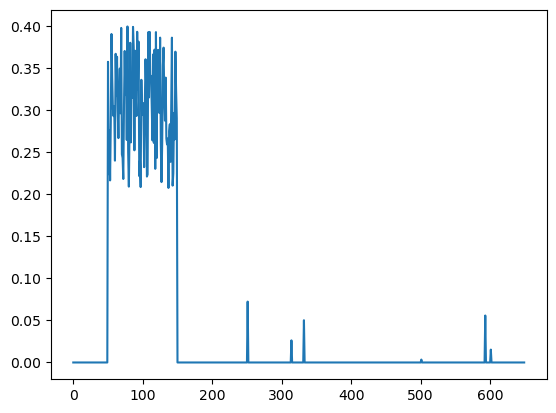

In [13]:
# Toy simulation : 
# || Initial switch_ratio 0.0, mid switch ratio big, late switch ratio small (but with fluctuations)
import torch 
from matplotlib import pyplot as plt

record = [0.0] * 50 + [abs(torch.rand(1).item() * 20 + 20)/100 for _ in range(100)] + [0.0] * 100 + [abs(torch.rand(1).item() * 8) * (torch.rand(1)>=0.98).item() /100 for _ in range(400)]

plt.plot(record)


In [3]:
switch_ratio

0.07692307692307693

In [19]:
from search import eval_generate_ppl

with torch.no_grad():
    greedy_ppl = eval_generate_ppl(gat, batch_data, 1, temperature=0.0, t_search=t_search)

    random_ppl = eval_generate_ppl(gat, batch_data, n, temperature=100.0, t_search=t_search)

In [25]:
from search import repeat_hseq, extend_abstract_tokens, pad_abstract_tokens

temperature = 100.0

repeat_batch = repeat_hseq(batch_data, n)

if t_search is not None: 
    extend_abstract_tokens(repeat_batch, t_search) 
else: 
    pad_abstract_tokens(repeat_batch) 

gat.generate(repeat_batch, parallel=True, temperature=temperature)


abstract_mask = (repeat_batch.levels > 0)
repeat_batch.tokens[abstract_mask]


tensor([5, 4, 7, 7, 5, 6, 6, 4, 1, 6, 4, 5, 3, 3, 5, 2, 5, 6, 4, 3, 2, 5, 4, 6,
        1, 2, 4, 2, 6, 7, 1, 1, 1, 5, 1, 6, 4, 7, 3, 7, 3, 3, 4, 7, 1, 7, 2, 3,
        5, 4, 3, 7, 3, 2, 1, 3, 4, 5, 5, 4, 3, 4, 4, 7, 2, 3, 2, 2, 5, 4, 3, 1,
        6, 1, 4, 4, 5, 1, 1, 2, 1, 6, 3, 4, 4, 6, 6, 6, 4, 7, 7, 5, 6, 5, 3, 7,
        5, 1, 5, 6, 7, 5, 2, 3, 1, 4, 4, 3, 2, 5, 6, 5, 1, 4, 6, 2, 3, 4, 1, 2,
        7, 1, 5, 7, 5, 2, 1, 2, 5, 4, 1, 2, 4, 1, 2, 1, 5, 7, 2, 6, 3, 5, 1, 1,
        1, 6, 7, 7, 3, 7, 7, 3, 3, 1, 7, 1, 6, 4, 3, 4, 6, 6, 7, 6, 7, 5, 5, 4,
        7, 4, 5, 3, 4, 4, 7, 5, 6, 1, 4, 4, 1, 2, 6, 6, 3, 4, 2, 6, 6, 1, 1, 7,
        1, 4, 5, 7, 3, 1, 2, 5, 4, 7, 2, 4, 1, 7, 1, 1, 4, 7, 1, 4, 5, 7, 1, 7,
        1, 3, 1, 7, 6, 6])

In [8]:
# evaluator for baseline transformer off ? 

from search import eval_generate_ppl


val_data = get_batch(id_val_dataset.sequences, id_val_dataset.lengths, context_length, gat.L, gat.K)
# traj_ppl_val = eval_ppl_with_search(val_data, gat, dataset.answer_token_id, n=6, temperature=1.0)

# eval_search_improvement(gat, val_data, t_search=t_search)

eval_generate_ppl(gat, val_data, n=1, temperature=0.0, t_search=t_search).mean()

tensor(1.4580, grad_fn=<MeanBackward0>)

In [7]:
val_data.tokens.size(0)

1016

In [3]:
sorl_search_v2(gat, batch_data, n, temperature, t_search, switch_abs_ppl_threshold=0.05) # pinned greedy sample ver.

HierSeq(tokens=tensor([ 9,  2,  0,  ...,  6, 11,  7]), levels=tensor([0, 0, 0,  ..., 0, 0, 0]), timestamps=tensor([ 1,  2,  3,  ..., 11, 12, 13]), sample_idx=tensor([ 0,  0,  0,  ..., 74, 74, 74]), batch_size=75, K=3, L=2, idx_map=tensor([18842, 18843, 18844, 18845, 18846, 18847, 18848, 18849, 18850, 18851,
        18852, 18853, 18854, 18855, 18856, 18857, 18858, 18859, 18860, 18861,
        18862, 18863, 18864, 18865, 18866, 18842, 18843, 18844, 18845, 18846,
        18847, 18848, 18849, 18850, 18851, 18852, 18853, 18854, 18855, 18856,
        18857, 18858, 18859, 18860, 18861, 18862, 18863, 18864, 18865, 18866,
        18842, 18843, 18844, 18845, 18846, 18847, 18848, 18849, 18850, 18851,
        18852, 18853, 18854, 18855, 18856, 18857, 18858, 18859, 18860, 18861,
        18862, 18863, 18864, 18865, 18866]))

In [4]:
batch_data = get_batch(id_val_dataset.sequences, id_val_dataset.lengths, context_length, gat.L, gat.K)
observe_abstraction(batch_data, gat, t_search, temperature=0.0)



'Sample 624 Abstract Tokens at level 1: [1, 1, 2, 2]\nSample 625 Abstract Tokens at level 1: [1, 1, 2, 2]\nSample 626 Abstract Tokens at level 1: [1, 1, 1, 2]\nSample 627 Abstract Tokens at level 1: [1, 1, 2]\nSample 628 Abstract Tokens at level 1: [1, 1, 2]\nSample 629 Abstract Tokens at level 1: [1, 1, 2, 2]\nSample 630 Abstract Tokens at level 1: [1, 1]\nSample 631 Abstract Tokens at level 1: [1, 2, 1, 2]\nSample 632 Abstract Tokens at level 1: [1, 2, 1, 2]\nSample 633 Abstract Tokens at level 1: [1, 1, 2]\nSample 634 Abstract Tokens at level 1: [1, 1, 2, 2]\nSample 635 Abstract Tokens at level 1: [1, 1, 2]\nSample 636 Abstract Tokens at level 1: [1, 1]\nSample 637 Abstract Tokens at level 1: [1, 2, 1, 2, 2]\nSample 638 Abstract Tokens at level 1: [1, 2, 2]\nSample 639 Abstract Tokens at level 1: [1, 1, 2, 2]\nSample 640 Abstract Tokens at level 1: [1, 1, 2, 2]\nSample 641 Abstract Tokens at level 1: [1, 1, 1, 2]\nSample 642 Abstract Tokens at level 1: [1, 2, 1, 2, 2]\nSample 643 Ab

In [ ]:
batch_data = get_batch(dataset.sequences, dataset.lengths, 64, gat.L, gat.K)

# Debug on threshold based argmax selection
# ------------------------------------------------------------
# repeat_batch, switch_ratio = sorl_search_v2(gat, batch_data, n, temperature, t_search, switch_abs_ppl_threshold=0.05)

from search import *
switch_abs_ppl_threshold=0.05
n = 5

ref_batch = generate_rollout_data(gat, batch_data, 1, 0.0, t_search)
explore_batch = generate_rollout_data(gat, batch_data, n-1, temperature, t_search)
ref_batch = concatenate_hseq(ref_batch, explore_batch)
ppt = gat(ref_batch)


# select | include threshold for weak-argmax selection that retains greedy sample (for stability)
# select_batch, switch_ratio = select_best_abstraction(ref_batch, ppt, switch_abs_ppl_threshold=switch_abs_ppl_threshold)

repeat_batch = ref_batch
traj_mask = (repeat_batch.levels[1:] == 0) & (repeat_batch.timestamps[1:] > 1)
traj_idx = repeat_batch.sample_idx[1:][traj_mask]
traj_ppl = ppt[traj_mask]

argmax_indices = compute_grouped_weak_argmax(traj_ppl, traj_idx, repeat_batch.idx_map, switch_abs_ppl_threshold)

# indices, values, idx_map = traj_idx, traj_ppl, repeat_batch.idx_map

#  # per-current-group mean (current indices)
# unique_indices, inverse = torch.unique(indices, return_inverse=True)
# n_indices = len(unique_indices)
# means = torch.zeros(n_indices).scatter_add_(0, inverse, values) / torch.bincount(inverse).float()

# # per-original-group argmax 
# orig_idx = idx_map[unique_indices]

# max_mask = compute_weak_group_argmax_mask(means, orig_idx, unique_indices, switch_abs_ppl_threshold)
# argmax_indices = unique_indices[max_mask]

# # weak_argmax_mask = torch.zeros(len(orig_idx), dtype=torch.bool)

# # for idx in orig_idx: 
# #     assert (indices[orig_idx == idx] == indices[orig_idx == idx].sort().values).all(), "First group is NOT the first appearance"

In [ ]:
assert means.size(0) == unique_indices.size(0) # each idx (rollout) gets a mean ppl
assert orig_idx.size(0) == means.size(0) # each mean ppl gets a orig idx
assert argmax_indices.size(0) == torch.unique(orig_idx).size(0) # picked indice is for each unique orig idx

# repeat_batch.indices
# repeat_batch.idx_map

In [ ]:
# orig_idx


5

In [ ]:
# def select_best_abstraction(repeat_batch: HierSeq, ppt: torch.Tensor, duplicate: bool = True) -> HierSeq: 
"""Pick best abstraction for each sample & repeat to original length"""
# explore
n = 3
repeat_batch = generate_rollout_data(gat, batch_data, n, temperature, t_search)

# evaluate 
ppt = gat(repeat_batch)

from search import * 

traj_mask = (repeat_batch.levels[1:] == 0) & (repeat_batch.timestamps[1:] > 1)
traj_idx = repeat_batch.sample_idx[1:][traj_mask]
traj_ppl = ppt[traj_mask]

argmax_indices = compute_grouped_argmax(traj_ppl, traj_idx, repeat_batch.idx_map)

# ideally we have a statistic here on how much 'switch abstraction' is happening

 

In [27]:
# Record: what is picked for each sample after-all ? 
# - when training data size is small, the improvement in improve_ppl is big and consistent. 
# - when training data size is large, the improvement in improve_ppl is small and inconsistent
# - small dataset has bigger chance of replaying the same sample ? 

from utils import HierSeq 
from collections import defaultdict

# version 0: buffer that records abstract tokens for each sample, no perplexity recorded yet
class Buffer: 
    def __init__(self, size: int): 
        self.size = size
        self.record = defaultdict(list)
    
    def update(self, hseq: HierSeq): 
        h_seqs, h_timestamps = hseq.to_hierarchical_data()
        for i, idx in enumerate(hseq.indices): 
            if hseq.idx_map is not None: 
                i = hseq.idx_map[idx] # original index in dataset
            self.record[i].append(h_seqs[i][1:]) # record abstract tokens only
            self.record[i].append(h_timestamps[i][1:])

buffer = Buffer(size=len(dataset.sequences))
buffer.update(batch_data)
buffer.record

defaultdict(list,
            {0: [[[]], [[]]],
             1: [[[]], [[]]],
             2: [[[]], [[]]],
             3: [[[]], [[]]],
             4: [[[]], [[]]],
             5: [[[]], [[]]],
             6: [[[]], [[]]],
             7: [[[]], [[]]],
             8: [[[]], [[]]],
             9: [[[]], [[]]],
             10: [[[]], [[]]],
             11: [[[]], [[]]],
             12: [[[]], [[]]],
             13: [[[]], [[]]],
             14: [[[]], [[]]],
             15: [[[]], [[]]],
             16: [[[]], [[]]],
             17: [[[]], [[]]],
             18: [[[]], [[]]],
             19: [[[]], [[]]],
             20: [[[]], [[]]],
             21: [[[]], [[]]],
             22: [[[]], [[]]],
             23: [[[]], [[]]],
             24: [[[]], [[]]],
             25: [[[]], [[]]],
             26: [[[]], [[]]],
             27: [[[]], [[]]]})

In [15]:
# len(dataset.sequences)
# batch_data.to_hierarchical_data()



In [3]:
# (TBD). 
# 1. Sitch temp=0.0 sampled HierSeq with temp>0.0 sampled HierSeq 
# 2. Test out improve_ppl of that scheme
from search import get_batch, generate_rollout_data, concatenate_hseq
from search import select_best_abstraction

batch_data = get_batch(dataset.sequences, dataset.lengths, 1024, gat.L, gat.K)

t_search = 3
temperature = 1.0
n = 1

# temp=0.0 sampled HierSeq
ref_hseq = generate_rollout_data(gat, batch_data, 1, 0.0, t_search)
# temp>0.0 sampled HierSeq
explore_hseq = generate_rollout_data(gat, batch_data, n, temperature, t_search)
# Sitch together (indices need extra care)
ref_hseq = concatenate_hseq(ref_hseq, explore_hseq)


# evaluate 
ppt = gat(ref_hseq)

# select
select_batch = select_best_abstraction(ref_hseq, ppt)



In [ ]:
# How about a dynamic temperature adjustment trick?
# - buffer only records 'ppl' per sample, and we would keep temperature=0.0 when ppl improve
# - when ppl stagnates, we'd increase the temperature a bit. 
# - given a batch, we'd compute the avg. temperature and apply uniformly on batch
# repeat_batch.idx_map
from collections import defaultdict

buffer = defaultdict(list)


batch_data = get_batch(dataset.sequences, dataset.lengths, context_length // n, gat.L, gat.K)

for _ in range(100): 
    ssl_loss = torch.rand(1)
    # update buffer
    for idx in batch_data.indices: 
        buffer[idx.item()].append(ssl_loss.item())
        buffer[idx.item()] = buffer[idx.item()][-10:]

    # compute avg. temperature | increase of ppl => increase temperature  
    #                          | drop on ppl_improve => decrease temperature










In [ ]:
buffer[13228]

# check ppl decrease


[0.7326294779777527,
 0.4336777925491333,
 0.9438287615776062,
 0.5409866571426392,
 0.9786422848701477,
 0.5516276955604553,
 0.7403034567832947,
 0.2659739851951599,
 0.18815654516220093,
 0.2615971565246582]

Idea: perhaps we could record ppl advantage against baseline (no abstraction) too? 

Evaluation: how do we evaluate the model? 

Incremental sample: what if we generate one abstraction at-a-time, do we still get the same benefit? 


Besides curriculum design, there is a more fundamental problem: the model is not learning to search here. Or rather, the language modeling loss, applied UNIFORMLY to all generated samples teaches the model to NOT DIFFERENTIATE between different choice of abstractions.


- language modeling loss is carried out on 'optimal trajectory' $x^{0}$ via minimizing negative log-likelihood $- \log \pi^{0}_{\theta}(x^{0})$, dynamic SFT adopts a variant of $- \pi^{0}_{\theta}(x) \log(\pi^{0}_{\theta}(x))$ to focus on 'easy case' and observe better performance than that of baseline model. 
- policy gradient method applied in GRPO, is basically a form of $- w(x^{1}) \log \pi^{1}_{\theta}(x^{1})$ the absense of optimal trajectory is compensated by a weight proportional to reward signal $r(x^{1})$. The weight adopted here focus on case with high reward / advantage. In the case of SoRL, reward of abstract token are provided by perplexity level of trajectory token, specifically, we have 
$$
r(x^{1}) = \pi^{0}_{\theta}(x^{0} | x^{1})
$$

- we can potentially unify the two things into one loss function, applied to all 'sampled' sequences via "unified loss"
$$
- \underbrace{\pi^{0}_{\theta}(x^{0} | x^{1}) \cdot \log \pi^{1}(x^{1})}_{\text{Policy Gradient for Abstraction}} - \underbrace{\pi^{0}_{\theta}(x^{0} | x^{1}) \cdot \log\pi^{0}(x^{0})}_{\text{Dynamic Language Modeling}}
$$


Above dynamic language modeling loss shrinks exponentially fast (due to exp(-logit) scaling effect) and doesn't work. We revert to a simple generate & pick & train approach with incremental t_search parameter, this significantly improves 'searching ability' of $\pi^{1}$ -- the picked abstraction $x^{1} \sim \pi^{1}(x^{0})$ is significantly better than abstraction selected at random -- it also creates a curriculum that interpolate from language modeling (no abstraction) to abstract modeling. 

Yep, and my brain just kept telling me there is another way that doesn't require "discarding" failing abstraction. 

But, the most important intuition is this: 

Observation: 
1. pure GRPO leads to negative & decreasing 'improve_ppl_percentage' value -- causing search ability to degrage!
2. joint GRPO + SSL training leads to 'improve_ppl_percentage' to increase initialy (first 80 epoch), but then degrades (!). 
3. joint GRPO + SSL training leads to 'RL_LOSS' to stay negative initially (first 80 epoch), but then goes positive (!). 
4. generally, accumulated 'rl loss' & 'improve_ppl_percentage' seems to be nagatively correlated -- decrease in rl loss leads to spike in 'improve_ppl_percentage'

Observation: 
- at around 80 iteration, policy collapse. rl_loss drastically increase, and 'improve_ppl_percentage' degrades.
- on 80 iteration, we are at the 1st iteration, completed 8 step each consisting of 10 joint iterations, therefore, it's the new data (randomly picked by the 'get_batch' functional) that's causing the policy collapse, this specific data point might be too hard for the current model to solve. But the real question is how do we 'detect' if the case is 'too hard'? 

Observation: 
- an error reveals a bad phenomenon, even when we iteratively search on one sample, the quality of rl_loss / ppl_improvement is not improving steadily? 
- The more basic problem is here: Does the search mechanism work on a single case ?? 
